In [1]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
testEmotions = '/Users/kaylienguyen/Downloads/FER_dataset/testrevised'
trainEmotions = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised'
image_directories_test = [
    os.path.join(testEmotions, "angry"),
    #os.path.join(testEmotions, "disgust"),
    os.path.join(testEmotions, "fear"),
    os.path.join(testEmotions, "happy"),
    os.path.join(testEmotions, "neutral"),
    os.path.join(testEmotions, "sad"),
    os.path.join(testEmotions, "surprise")
]
image_directories_train = [
    os.path.join(trainEmotions, "angry"),
    #os.path.join(trainEmotions, "disgust"),
    os.path.join(trainEmotions, "fear"),
    os.path.join(trainEmotions, "happy"),
    os.path.join(trainEmotions, "neutral"),
    os.path.join(trainEmotions, "sad"),
    os.path.join(trainEmotions, "surprise")
]

def get_first_image(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            return os.path.join(directory, filename)
        
train_images = [get_first_image(directory) for directory in image_directories_train]
display(train_images)

['/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/angry/Training_35668808.jpg',
 '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/fear/Training_19995150.jpg',
 '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/happy/Training_50449107.jpg',
 '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/neutral/Training_27707774.jpg',
 '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/sad/Training_86437620.jpg',
 '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised/surprise/Training_53079763.jpg']

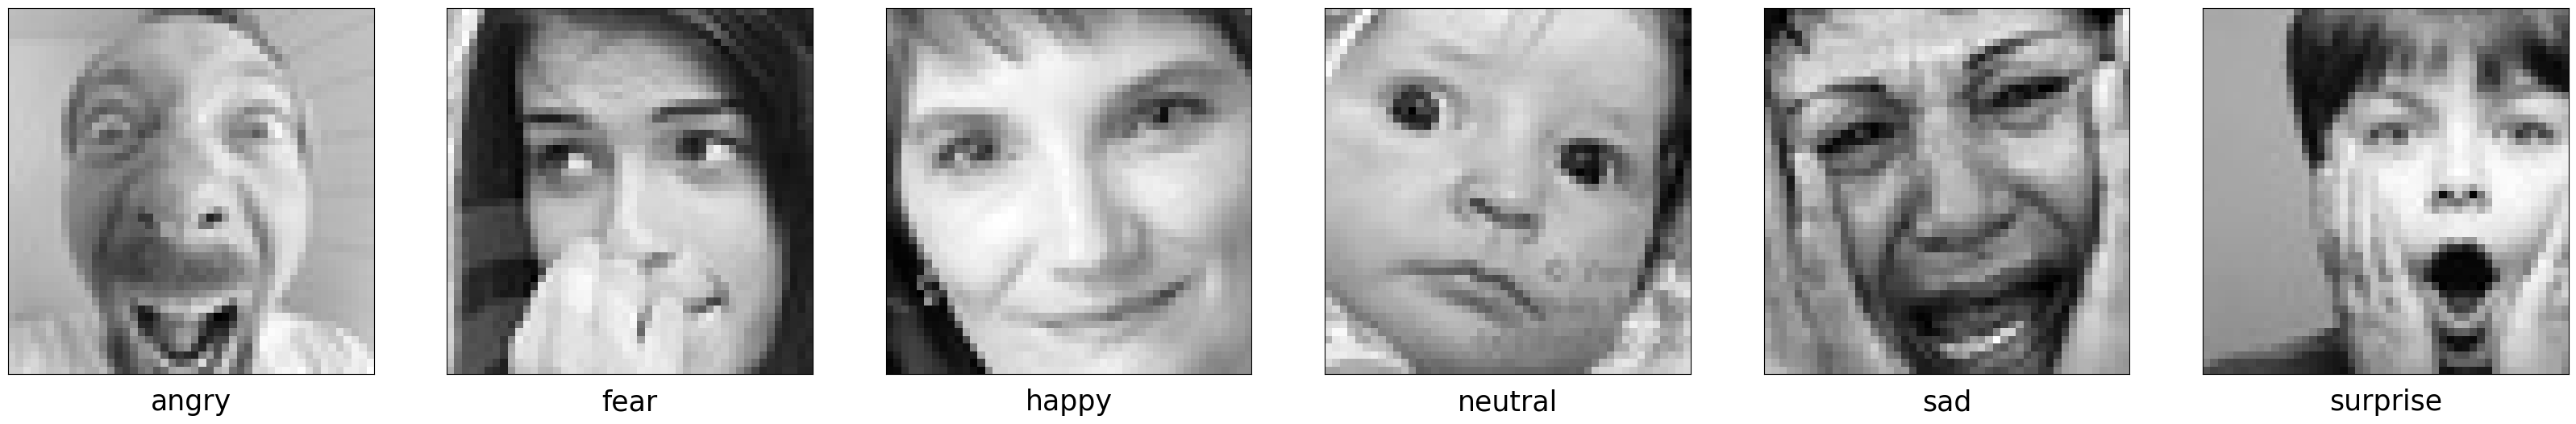

In [3]:
plt.figure(figsize=(48, 48))
for i in range(len(train_images)):
    ax = plt.subplot(2, 7, i + 1)
    image = Image.open(train_images[i])
    plt.imshow(image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    emotion_label = train_images[i].split("/")[-2]
    
    plt.text(0.5, -0.1, emotion_label, horizontalalignment='center', fontsize=25, transform=ax.transAxes)

plt.show()

In [4]:
#pre-processing

def get_image_paths_and_labels(image_directories):
    image_paths = []
    labels = []

    for i, directory in enumerate(image_directories):
        emotion_label = os.path.basename(directory)
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(directory, filename))
                labels.append(emotion_label)

    return image_paths, labels

train_image_paths, train_labels = get_image_paths_and_labels(image_directories_train)
test_image_paths, test_labels = get_image_paths_and_labels(image_directories_test)

print("Number of train images:", len(train_image_paths))
print("Number of test images:", len(test_image_paths))

Number of train images: 28179
Number of test images: 6961


In [7]:
def load_and_preprocess_images(image_paths, img_width, img_height):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

img_width = 48
img_height = 48

X_train = load_and_preprocess_images(train_image_paths, img_width, img_height)
X_test = load_and_preprocess_images(test_image_paths, img_width, img_height)

label_encoder = LabelEncoder()

# Fit and transform the labels for training data
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert the encoded labels to one-hot encoded vectors
y_train = to_categorical(train_labels_encoded)
y_test = to_categorical(test_labels_encoded)

In [13]:
# build a model
input_shape = (img_width, img_height, 3)

model = Sequential([
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),

    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=200, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(6, activation='softmax')
])

epochs = 20
batch_size = 32

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
#early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss: ', test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
705/705 [==============================] - 549s 774ms/step - loss: 1.4780 - accuracy: 0.3764 - val_loss: 6.1591 - val_accuracy: 0.0000e+00
Epoch 2/20
691/705 [============================>.] - ETA: 10s - loss: 1.2373 - accuracy: 0.5013

KeyboardInterrupt: 